In [24]:
!pip install -U seaborn-image
import torch
import torch.nn as nn
import torchvision as tv
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
import cv2

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

  Using cached importlib_metadata-1.7.0-py2.py3-none-any.whl (31 kB)
  Attempting uninstall: importlib_metadata
    Found existing installation: importlib-metadata 4.2.0
    Uninstalling importlib-metadata-4.2.0:
      Successfully uninstalled importlib-metadata-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
virtualenv 20.17.1 requires importlib-metadata>=4.8.3; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
pynndescent 0.5.8 requires importlib-metadata>=4.8.1; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
pydocstyle 6.2.3 requires importlib-metadata<5.0.0,>=2.0.0; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
nbformat 5.7.3 requires importlib-metadata>=3.6; python_version < "3.8",

In [25]:
faces_data = np.load("/kaggle/input/olivetti-faces/olivetti_faces.npy")
faces_target = np.load("/kaggle/input/olivetti-faces/olivetti_faces_target.npy")
faces_data.shape, faces_target.shape

((400, 64, 64), (400,))

In [26]:
state_dict = {}
for i in range(len(faces_data)):
    if faces_target[i] not in state_dict:
        state_dict[faces_target[i]]=[i,i]
    else:
        state_dict[faces_target[i]][1]+=1

In [27]:
resnet50 = tv.models.resnet50(tv.models.ResNet50_Weights.DEFAULT)
# print(resnet50)

In [28]:
TRAIN_DIR = r"/kaggle/input/omniglot/images_background"
TEST_DIR = r"/kaggle/input/omniglot/images_evaluation"

from pathlib import Path
import os

def dir_info(path: str):
    if Path(path).exists():
        nclasses = len(set(Path(path).iterdir()))
        class_names = [entry.name for entry in list(os.scandir(path))]
        class_to_idx = {cl:i for i,cl in enumerate(class_names)}
        print(f"BASE PATH: {path}")
        print(f"CLASS COUNT: {nclasses}")
        print(f"CLASS_INDEX: {class_to_idx}\n\n")
        
dir_info(TRAIN_DIR)
dir_info(TEST_DIR)

BASE PATH: /kaggle/input/omniglot/images_background
CLASS COUNT: 30
CLASS_INDEX: {'Grantha': 0, 'Armenian': 1, 'Greek': 2, 'Syriac_(Estrangelo)': 3, 'Latin': 4, 'Mkhedruli_(Georgian)': 5, 'Futurama': 6, 'Bengali': 7, 'Gujarati': 8, 'Alphabet_of_the_Magi': 9, 'Cyrillic': 10, 'Malay_(Jawi_-_Arabic)': 11, 'N_Ko': 12, 'Korean': 13, 'Burmese_(Myanmar)': 14, 'Tifinagh': 15, 'Asomtavruli_(Georgian)': 16, 'Arcadian': 17, 'Balinese': 18, 'Blackfoot_(Canadian_Aboriginal_Syllabics)': 19, 'Tagalog': 20, 'Inuktitut_(Canadian_Aboriginal_Syllabics)': 21, 'Ojibwe_(Canadian_Aboriginal_Syllabics)': 22, 'Japanese_(katakana)': 23, 'Japanese_(hiragana)': 24, 'Anglo-Saxon_Futhorc': 25, 'Braille': 26, 'Sanskrit': 27, 'Hebrew': 28, 'Early_Aramaic': 29}


BASE PATH: /kaggle/input/omniglot/images_evaluation
CLASS COUNT: 20
CLASS_INDEX: {'Sylheti': 0, 'Keble': 1, 'Atemayar_Qelisayer': 2, 'Tibetan': 3, 'Aurek-Besh': 4, 'Ge_ez': 5, 'Glagolitic': 6, 'Oriya': 7, 'Gurmukhi': 8, 'Mongolian': 9, 'Kannada': 10, 'Syriac_

In [29]:
'''X.shape, y.shape'''

# hierarchy
# X -> [ [Lang1_charac1_img1(105 X 105)...Lang1_charac1_img20],[Lang1_charac2_img1...Lang1_charac2_img20],......,[Lang2_charac1_img1...Lang2_charac1_img20] ]
# y -> [ 1D array of labels]
# lang_dict -> { Language: Range to access characters of the lang}

'X.shape, y.shape'

In [30]:
class MinMaxScaler(object):
    """
    Transforms each channel to the range [0, 1].
    """
    def __call__(self, tensor):
        for ch in tensor:
            scale = 1.0 / (ch.max() - ch.min())
            ch.mul_(scale).sub_(ch.min().mul_(scale))
        return tensor

In [31]:
TRAIN_DATA_SIZE = 4800
TEST_DATA_SIZE = 32

In [32]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=1),
    transforms.Resize((64, 64)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

In [33]:
class CustomFacesPairs(Dataset):
    def __init__(self,data:List[float],target:List[int],transform=None,length=100) -> None:
        self.data = data
        self.target = target
        self.transform = transform
        self.length = length
    
    def __len__(self) -> int:
        return self.length
    
    def __getitem__(self,index:int):
        idx1 = random.randint(0,399)
        tgt1 = idx1//10
        
        idx2=idx1 # Temp values
        idx3=idx1
        
        if index%2:
            # If index is odd - same images
            while(idx2==idx1): #Not same img, but within same class
                idx2 = random.randint(tgt1*10, tgt1*10 + 9) 
        else:
            # If index is even - diff images
            while(idx2//10 == tgt1): #Not same class/target
                idx2 = random.randint(0,399)

        img1 = self.data[idx1]
        img2 = self.data[idx2]
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            return img1,img2,index%2
        return img1,img2,index%2


class CustomFacesTriplets(Dataset):
    def __init__(self,data:List[float],target:List[int],transform=None,length=100) -> None:
        self.data = data
        self.target = target
        self.transform = transform
        self.length = length
    
    def __len__(self) -> int:
        return self.length
    
    def __getitem__(self,index:int):
        idx1 = random.randint(0,399)
        tgt1 = idx1//10
        
        idx2=idx1 # Temp values
        idx3=idx1

        while(idx2==idx1): # positive image
                idx2 = random.randint(tgt1*10, tgt1*10 + 9) 
        while(idx3//10 == tgt1): # negative image
                idx3 = random.randint(0,399)
        anchor = self.data[idx1]
        pos = self.data[idx2]
        neg = self.data[idx3]
        if self.transform:
            anchor = self.transform(anchor)
            pos = self.transform(pos)
            neg = self.transform(neg)
            return anchor,pos,neg
        return anchor,pos,neg
            
train_dataset_p = CustomFacesPairs(faces_data,faces_target,train_transform,TRAIN_DATA_SIZE)
test_dataset_p = CustomFacesPairs(faces_data,faces_target,train_transform,TEST_DATA_SIZE)

train_dataset_t = CustomFacesTriplets(faces_data,faces_target,train_transform,TRAIN_DATA_SIZE)
test_dataset_t = CustomFacesTriplets(faces_data,faces_target,train_transform,TEST_DATA_SIZE)

In [34]:
BATCH_SIZE_P = 32
BATCH_SIZE_T = 32

train_dataloader_p = DataLoader(dataset=train_dataset_p,batch_size=BATCH_SIZE_P,shuffle=True)
test_dataloader_p = DataLoader(dataset=test_dataset_p,batch_size=BATCH_SIZE_P)

train_dataloader_t = DataLoader(dataset=train_dataset_t,batch_size=BATCH_SIZE_T,shuffle=True)
test_dataloader_t = DataLoader(dataset=test_dataset_t,batch_size=BATCH_SIZE_T)

Image Pairs and Labels
Labels: [0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0]
Image Pairs and Labels


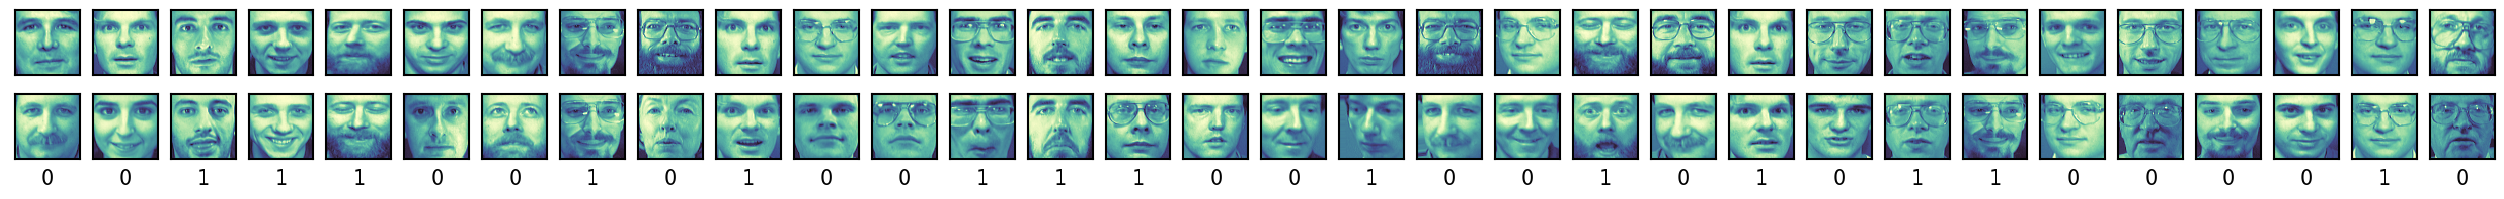

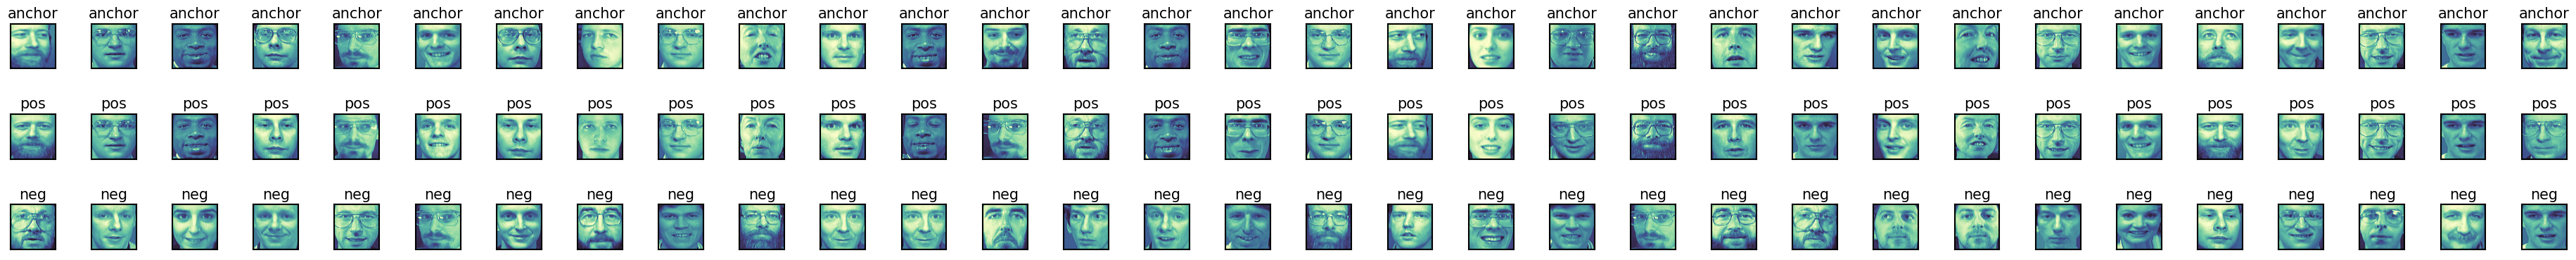

In [35]:
# Extract one batch
example_batch = next(iter(train_dataloader_p))

pair_imgs=2
trip_imgs=3

# Example batch is a list containing 3x1 images&labels [0] - [8,1,64,64], [1] - [8,1,64,64],[2] - [8,]
# If the label is 0, it means that it is not the same person, label is 1, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
fig = plt.figure(figsize=(BATCH_SIZE_P,pair_imgs))
for i in range(concatenated.shape[0]):
    fig.add_subplot(pair_imgs,BATCH_SIZE_P,i+1)
    if i//BATCH_SIZE_P == 1: # Considers the last row of images to add xlabel
        plt.xlabel(example_batch[2].numpy().reshape(-1)[i%BATCH_SIZE_P])
    plt.yticks([])
    plt.xticks([])
    plt.imshow(concatenated[i].permute(1,2,0))
print("Image Pairs and Labels")
print("Labels:",example_batch[2].numpy().reshape(-1))
    
example_batch = next(iter(train_dataloader_t))
concatenated = torch.cat((example_batch[0], example_batch[1],example_batch[2]),0)
labels = ["anchor","pos","neg"]
fig,ax = plt.subplots(trip_imgs,BATCH_SIZE_T,figsize=(BATCH_SIZE_T+5,trip_imgs+1))
plt.tight_layout()
for i in range(concatenated.shape[0]):
    ax[i//BATCH_SIZE_T,i%BATCH_SIZE_T].set_title(labels[i//BATCH_SIZE_T])
    ax[i//BATCH_SIZE_T,i%BATCH_SIZE_T].set_xticks([])
    ax[i//BATCH_SIZE_T,i%BATCH_SIZE_T].set_yticks([])
    ax[i//BATCH_SIZE_T,i%BATCH_SIZE_T].imshow(concatenated[i].permute(1,2,0))

print("Image Pairs and Labels")   

In [36]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return torch.nn.functional.pairwise_distance(x1, x2)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [37]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(512),
            nn.PReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
            
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1)
        x = self.fc(x)
        return x

In [ ]:
# Declare Siamese Network
net = Network().cuda()
# Decalre Loss Function
criterion = nn.TripletMarginLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

EPOCHS = 30
#train the model
def training():
    loss=[] 
    counter=[]
    iteration_number = 0
    for epoch in tqdm(range(EPOCHS),desc="EPOCHS"):
        for i, data in enumerate(tqdm(train_dataloader_t,desc="Training", leave=False)):
            img0, img1 ,img2 = data
            img0, img1 ,img2 = img0.cuda(), img1.cuda() , img2.cuda()
            optimizer.zero_grad()
            output0,output1,output2 = net(img0),net(img1),net(img2)
            loss_trip = criterion(output0,output1,output2)
            if loss_trip.item() != 0:  # Check if the loss is not zero
                loss_trip.backward()
                optimizer.step()
            
#         print("Epoch {}\n Current loss {}\n".format(epoch,loss_trip.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_trip.item())
#     plt.plot(counter, loss)   
    return net

#set the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = training()
torch.save(model.state_dict(), "model_triplet.pt")
print("Model Saved Successfully") 

torch.Size([1, 1, 64, 64])
tensor(11.4728) tensor(33.7345)
Image Pairs and Labels


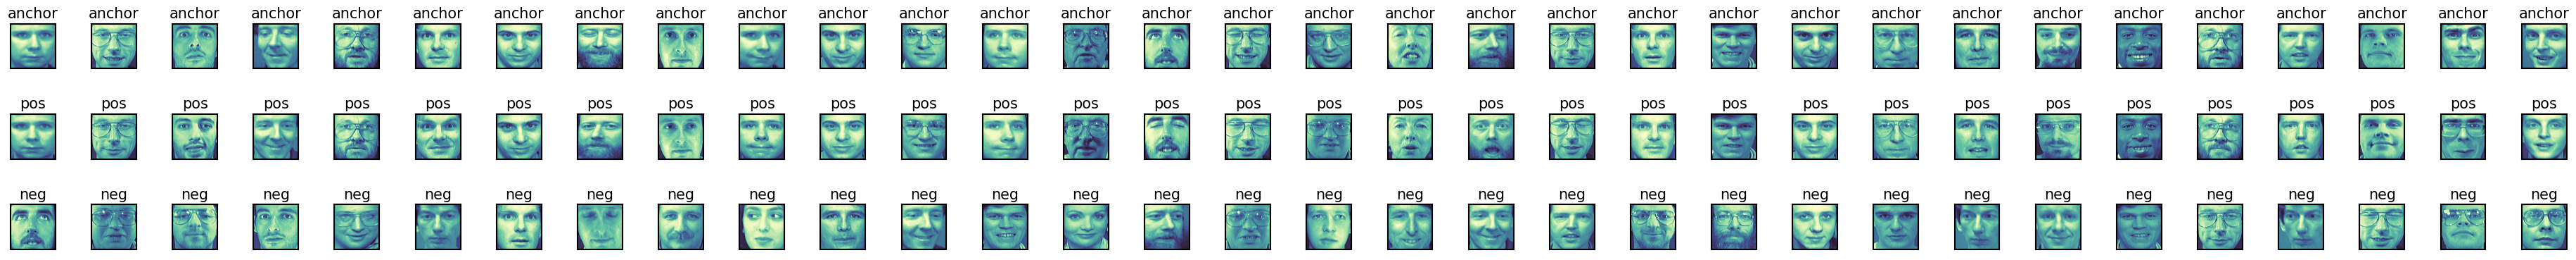

In [39]:
for i, data in enumerate(test_dataloader_t): 
    x0, x1 , x2 = data
    concat = torch.cat((x0,x1,x2),0)
    model = Network()
    model.load_state_dict(torch.load("/kaggle/working/model_triplet.pt"))
    print(x0[0].unsqueeze(0).shape)
    
    with torch.no_grad():
        model.eval()
        output1 = model(x0)
        output2 = model(x1)
        output3 = model(x2)

    pos_distance = F.pairwise_distance(output1, output2)
    neg_distance = F.pairwise_distance(output1, output3)
    print(pos_distance,neg_distance)

    concatenated = torch.cat((x0,x1,x2),0)
    labels = ["anchor","pos","neg"]
#     fig = plt.figure(figsize=(BATCH_SIZE,OUTPUT_IMGS))
    fig,ax = plt.subplots(trip_imgs,BATCH_SIZE_T,figsize=(BATCH_SIZE_T+5,trip_imgs+1))
    plt.tight_layout()
    for i in range(concatenated.shape[0]):
        ax[i//BATCH_SIZE_T,i%BATCH_SIZE_T].set_title(labels[i//BATCH_SIZE_T])
        ax[i//BATCH_SIZE_T,i%BATCH_SIZE_T].set_xticks([])
        ax[i//BATCH_SIZE_T,i%BATCH_SIZE_T].set_yticks([])
        ax[i//BATCH_SIZE_T,i%BATCH_SIZE_T].imshow(concatenated[i].permute(1,2,0))

    print("Image Pairs and Labels")   

In [40]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.|
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [41]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=5,stride=1),
            nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.BatchNorm2d(96),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.LazyLinear(1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True)
#             nn.Linear(128,2)
        )
        
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

0it [00:00, ?it/s]

Epoch 0
 Current loss 0.07609552145004272



0it [00:00, ?it/s]

Epoch 1
 Current loss 0.0897136926651001



0it [00:00, ?it/s]

Epoch 2
 Current loss 0.06448128074407578



0it [00:00, ?it/s]

Epoch 3
 Current loss 0.05098387598991394



0it [00:00, ?it/s]

Epoch 4
 Current loss 0.03832855448126793



0it [00:00, ?it/s]

Epoch 5
 Current loss 0.0329587459564209



0it [00:00, ?it/s]

Epoch 6
 Current loss 0.032910946756601334



0it [00:00, ?it/s]

Epoch 7
 Current loss 0.029343146830797195



0it [00:00, ?it/s]

Epoch 8
 Current loss 0.022796541452407837



0it [00:00, ?it/s]

Epoch 9
 Current loss 0.017990976572036743



0it [00:00, ?it/s]

Epoch 10
 Current loss 0.025117091834545135



0it [00:00, ?it/s]

Epoch 11
 Current loss 0.0257552582770586



0it [00:00, ?it/s]

Epoch 12
 Current loss 0.01863623969256878



0it [00:00, ?it/s]

Epoch 13
 Current loss 0.03197057545185089



0it [00:00, ?it/s]

Epoch 14
 Current loss 0.02415849268436432



0it [00:00, ?it/s]

Epoch 15
 Current loss 0.016665223985910416



0it [00:00, ?it/s]

Epoch 16
 Current loss 0.03352802246809006



0it [00:00, ?it/s]

Epoch 17
 Current loss 0.019290108233690262



0it [00:00, ?it/s]

Epoch 18
 Current loss 0.014451523311436176



0it [00:00, ?it/s]

Epoch 19
 Current loss 0.014709838666021824



0it [00:00, ?it/s]

Epoch 20
 Current loss 0.006622198037803173



0it [00:00, ?it/s]

Epoch 21
 Current loss 0.012219716794788837



0it [00:00, ?it/s]

Epoch 22
 Current loss 0.012533730827271938



0it [00:00, ?it/s]

Epoch 23
 Current loss 0.019203104078769684



0it [00:00, ?it/s]

Epoch 24
 Current loss 0.015497486107051373

Model Saved Successfully


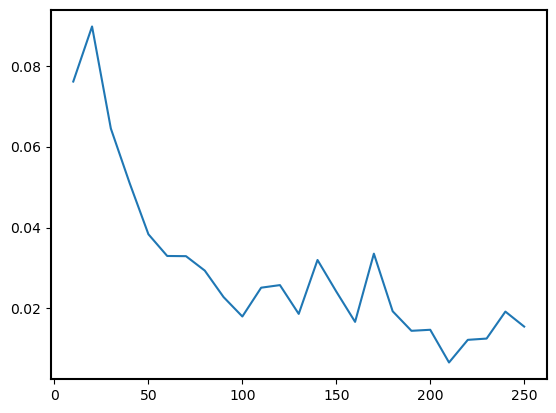

In [42]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

EPOCHS = 25
#train the model
def training():
    loss=[] 
    counter=[]
    iteration_number = 0
    for epoch in range(EPOCHS):
        for i, data in tqdm(enumerate(train_dataloader_p)):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()    
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    plt.plot(counter, loss)   
    return net

#set the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = training()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully") 

torch.Size([32, 1, 64, 64])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


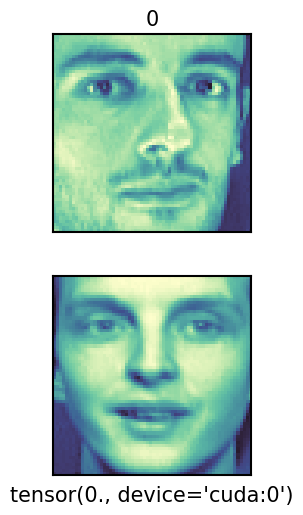

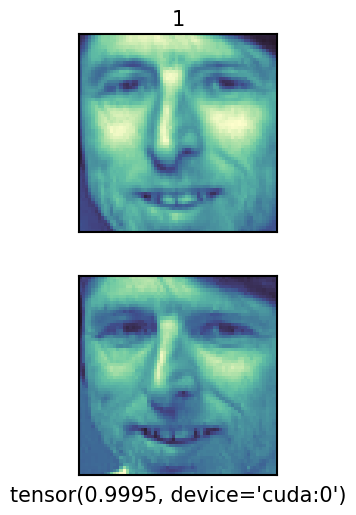

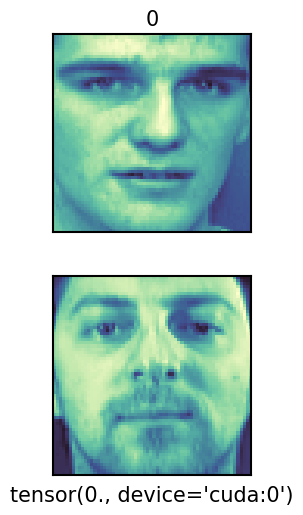

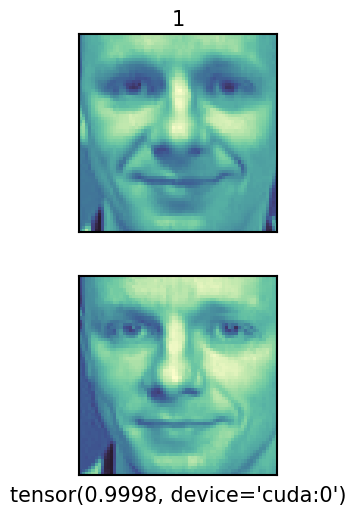

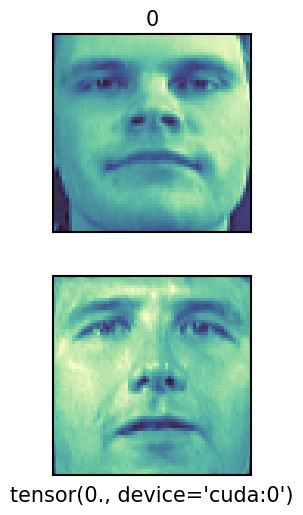

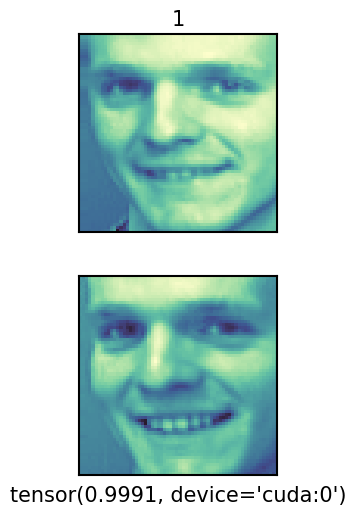

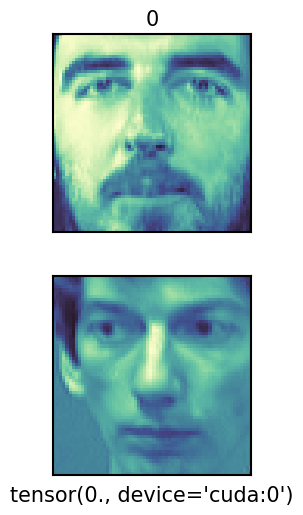

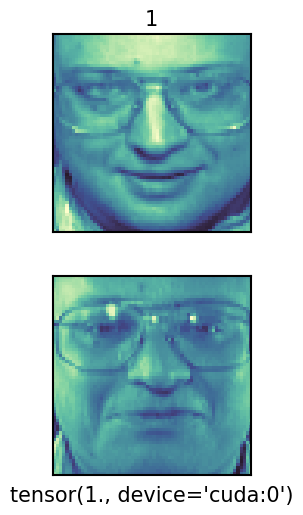

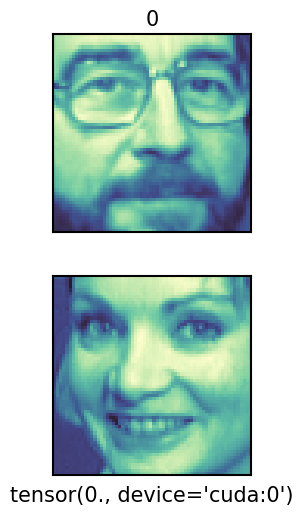

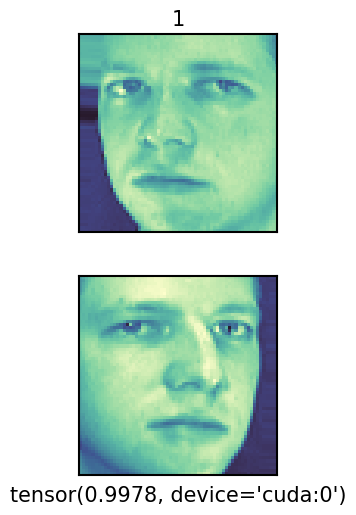

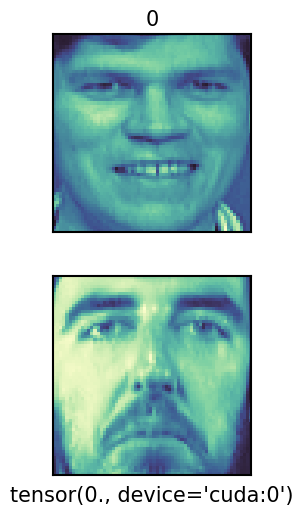

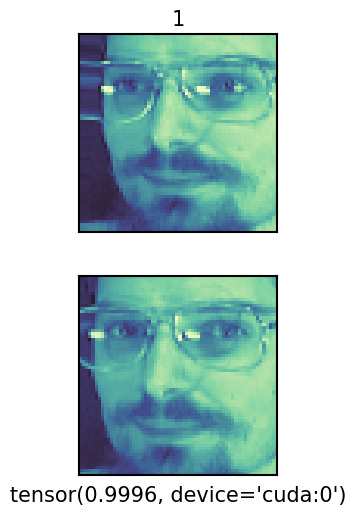

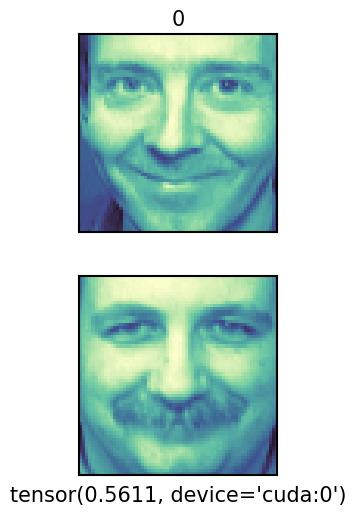

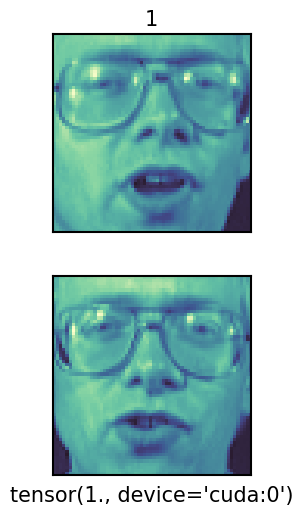

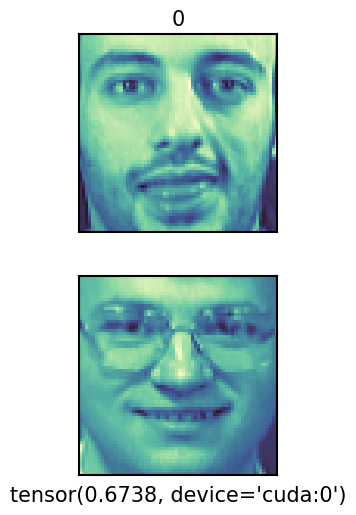

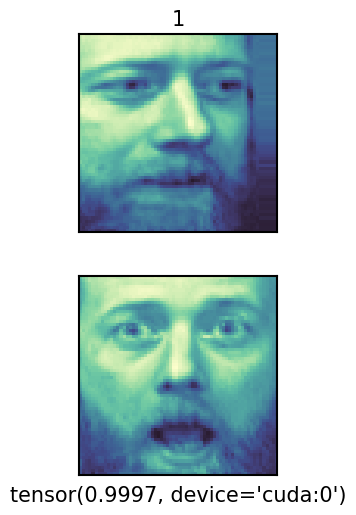

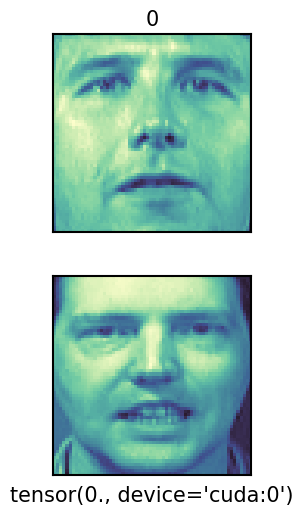

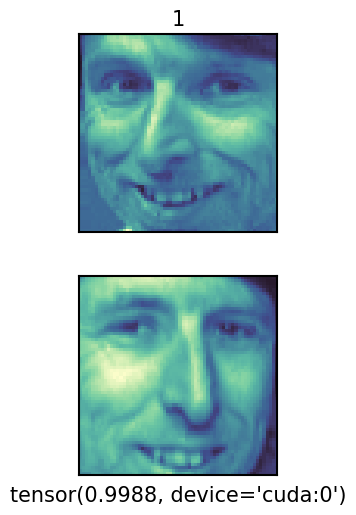

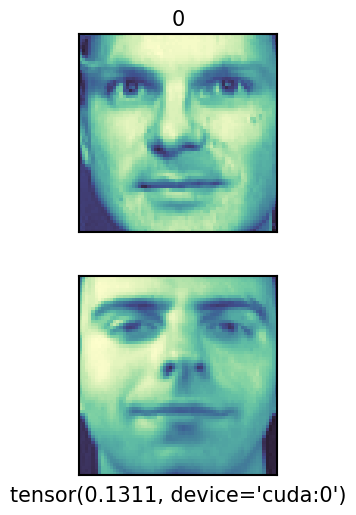

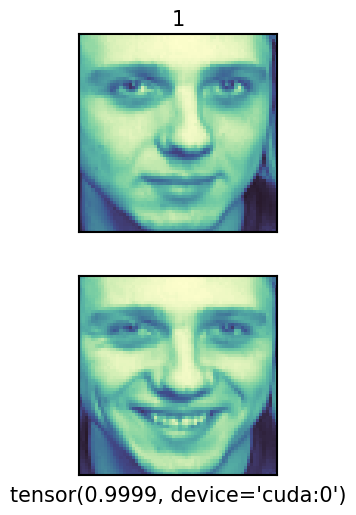

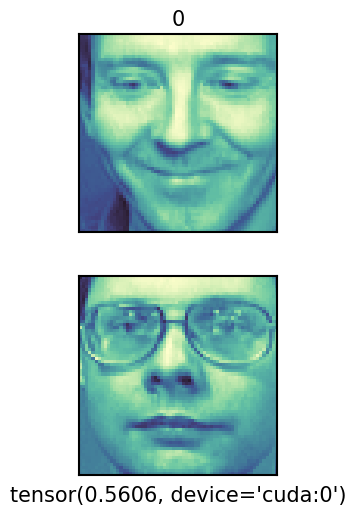

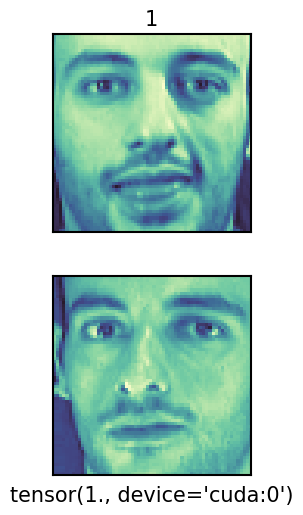

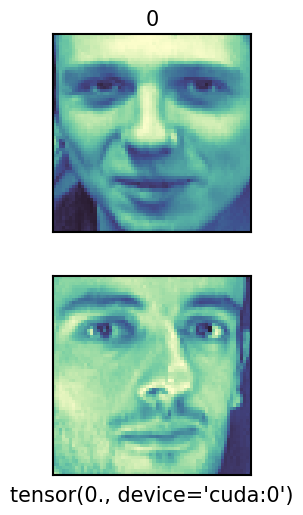

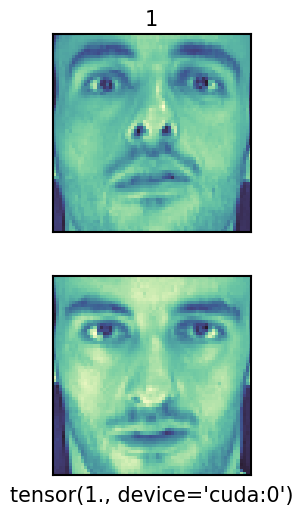

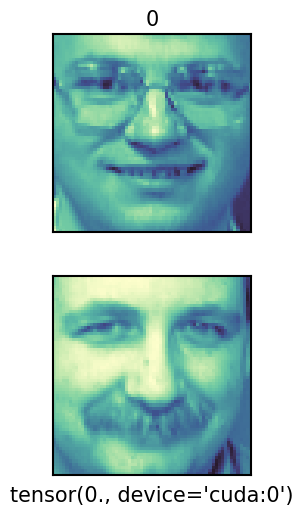

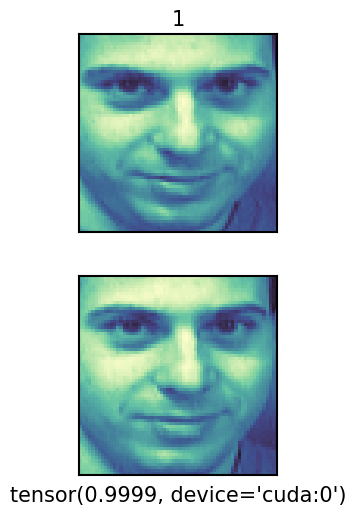

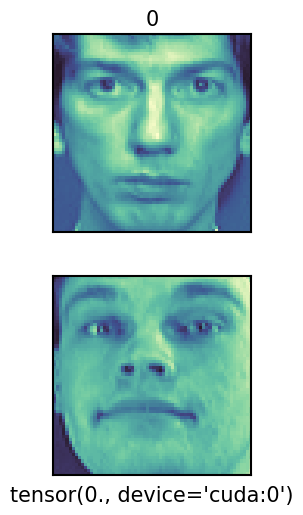

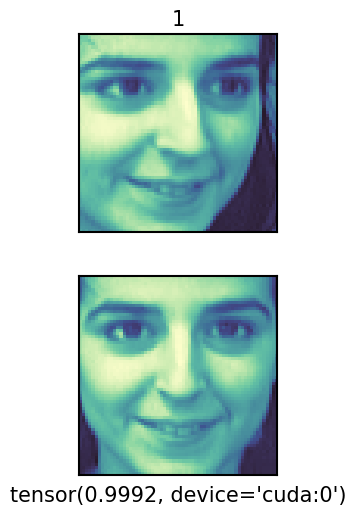

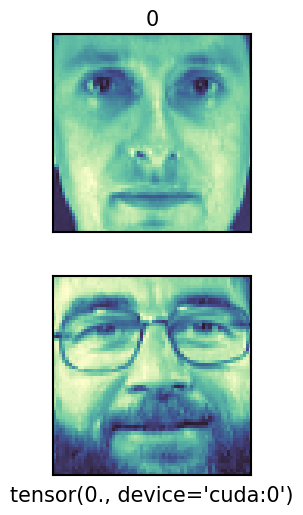

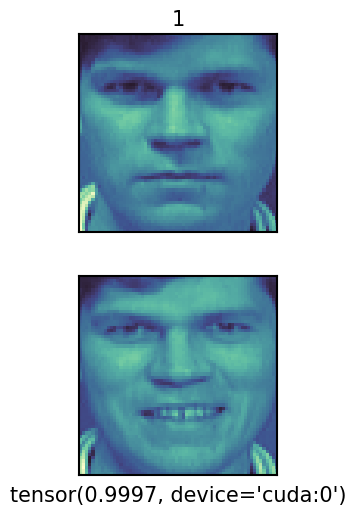

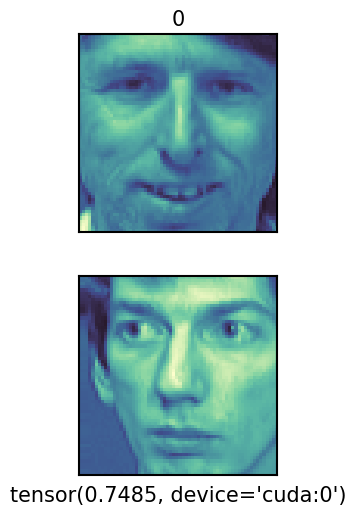

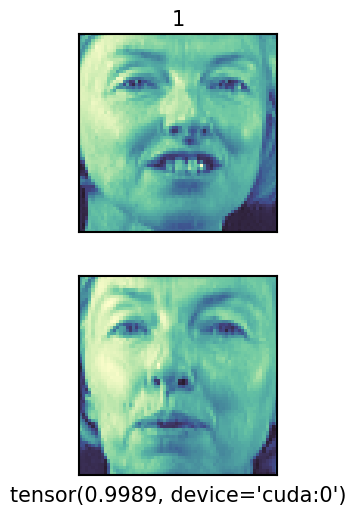

In [44]:
for i, data in enumerate(test_dataloader_p): 
    x0, x1 , label = data
    
    pair_imgs=2
    trip_imgs=3

    # Example batch is a list containing 3x1 images&labels [0] - [8,1,64,64], [1] - [8,1,64,64],[2] - [8,]
    # If the label is 0, it means that it is not the same person, label is 1, same person in both images
    model.eval()
    with torch.no_grad():
        x0,x1 = x0.cuda(),x1.cuda()
        out1,out2 = model(x0,x1)
        res = F.cosine_similarity(out1, out2)
        x0,x1 = x0.cpu(),x1.cpu()
        print(x0.shape)
        
#         accuracy = sum([1 if label[i].item()==res[i] for i in range(len(label))])/len(label)
#         print(accuracy)
        
        for i in range(len(label)):
            fig,ax = plt.subplots(pair_imgs,1,figsize=(pair_imgs+5,5))
            plt.tight_layout()
            ax[0].set_title(label[i].item())
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            ax[0].imshow(x0[i].permute(1,2,0))
            
            ax[1].set_xticks([])
            ax[1].set_yticks([])
            ax[1].set_xlabel(res[i])
            ax[1].imshow(x1[i].permute(1,2,0))